# Hypothesis tests

In this Notebook I´m going to clarify some aspects of one fundamental data analyst tool: **Hypothesis tests**

We will have a walk over:

First Notebook:
- $\mathit{z}$-Scores
- $\mathit{p}$-Values
- Confidence Intervals
- $\mathit{t}$-Tests
- ANOVA

Second Notebook:

- Tests for single and two proportions
- Proportions $\mathit{z}$-test
- ${Chi^{2}}$ tests
- Wilcoxon tests
- Wilcoxon-Man-Whotney tests
- Kruskal-Wallis tests

## Definitions

So, first of all, what is a hypothesis tests?

**Hypothesis tests** is a mathematical procedure that allow us to generalize hypothesis / properties that we supposed based on our data, so what we deduce from our sample could be a real property of that population.

**A/B Testing** is a process that allow us to check outcomes of competing scenarios and decide which way to proceed depending of the results that this scenarios provide us. 
- For example, if we are in the medicine field, a common hypothesis test is to separate two groups of people to give them medicine and placebo respectivelly in order to see if the medicine really works or it is based on the suggestion of the patient. 
- Another example is when you perform a separation in a website in order to have two websites and see the SEO, how it is positioning, how is it listed on the internet and decide which interface is better.
  
A/B Testing is the main application of Hypothesis tests.

!["A/B Testing Image"](https://www.optimizely.com/contentassets/08726e145f1b4743a0ba2f30c0447b76/ab-testing.png)

# Hypothesis testing fundamentals

To learn more about hypothesis tests, we will be working with two datasets, one that is called *late_shipments* and the other one called *republican_votes*. Right now we will be using only the first one in order to understand more about hypothesis tests.

The *late_shipments* dataset contains supply chain data on the delivery of medical supplies. Each row represents one delivery of a part. 
- The **"late"** columns denotes whether or not the part was delivered late. A value of "Yes" means that the part was delivered late, and a value of "No" means the part was delivered on time.

Also, for temporal comparing datasets we will use *repub_votes_potus_08_12* that has comparisons of the votes between republicans and democrats betweenn those years.

- Since the counties are the same in both years, these samples are paired (Used in the paired t-test chapter). The columns containing the samples are *"dem_percent_12"* and *"dem_percent_16"*.

## Packages and dataset main idea

In [53]:
import pandas as pd
import pyarrow.feather as feather
import numpy as np 
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

Let´s find some information first about the shipments, how many of them are late shipments? First, as we usually do we have a previsualization of the datasets.

In [39]:
late_shipments = feather.read_feather("late_shipments.feather")
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


We can know this by having a look to the column *"late"* and making a proportion. As it is a *dummy variable*, we only have to take the mean.

In [40]:
# Calculate the proportion of late shipments
late_prop_samp = (late_shipments["late"]=="Yes").mean()
print(late_prop_samp)

0.061


So we obtain that **6.1%** of the shipments are late. 
The point is, **can we make this results general for every sample of our shipments**? 

## Z-Score

Imagine that you are in your house with your cousin from Romania and you want to compare how much money do you have in your piggy bank! It is usually use to save money specially as a child to learn a bit of finances and self-control, and both of you want to know who is the best one saving money for some ice cream! 💰🐷

Then, you decide to open the piggy bank (Opening means 🔨), but, when you open it you discover something...
Your cousing has Leis on it! The standard coind in Romania while you have Euros! How are you going to compare both quantities?
Your cousin could have saved 6 coins, but the value of his coins not the same as yours... What can we do?

**This is the purpose of the $\mathit{z}$-Score, to standarized the value of interest for our statistic.**

To calculate it, you need three numbers: 
- The sample statistic (point estimate)
- The hypothesized statistic
- The standard error of the statistic (estimated from the bootstrap distribution)


Now, we are going to calculate the $\mathit{z}$-Score <a id='z-Score'></a>
 of our problem, this is, we are going to compare samples of our shipments population and see if they are really deviated from the media of our hypothesis.

Our numbers are:
- The sample statistic, we will pick samples from it **using a BootStrap distribution**.
- The hypothesized statistic, this is **0.06** (or 6%)
- The standard error of the statistic, **we can calculate it from the first number with NumPy**.

$$ \mathit{z}-Score = \frac{Sample stat - Hypot. param. value}{Standard error}$$

1. Sample statistic with Bootstrap Sampling:

In [41]:
#--------------------------BootStrap-Sampling------------------

late_shipments['late'] = late_shipments['late'].map({'Yes': 1, 'No': 0}) #Tranform the strings into ints
#-----Looping----------

late_shipments_boot_distn = []
for i in range(1000):
    late_shipments_boot_distn.append(
        np.mean(
            late_shipments.sample(frac=1,replace = True)["late"]
    )
)

2. Hypothesized statistic

In [42]:
late_prop_hyp = 0.06

3. Standard error from the Bootstrap Distribution

In [43]:
std_error = np.std(late_shipments_boot_distn, ddof=1)
std_error

0.007482042298527653

So we calculate the $\mathit{z}$-score:

In [44]:
z_score = (late_prop_samp - late_prop_hyp) / std_error
# Print z_score
print(z_score)

0.13365334758890432


So, we obtain that the standarized measure difference is 0.13255 aproximately!

-----------------------------

## p-Value

### Hypothesis and tails

We will now see why $\mathit{z}$-Score is so important and what is the relation that it has with $\mathit{p}$-Value!

But first, it is mandatory to explain some things! Imagine that your cousin and you are arguing about your money: Is it the same? Does he have more than you? And the opposite case?

All of this assumptions are hypothesis.**A hypothesis is a statement about an unknown population parameter.**
When we are comparing two hypothesis to see which one is true it is called a **hypothesis test**. These hypothesis are called:

- Null hypothesis ($H_{0}$) which is the existing idea.
- Alternative hypothesis ($H_{A}$) that is the one that challenges the previous idea.

In our case it could be that our $H_{0}$ has more money than and the $H_{A}$ is that he do not have more money than I.

![Money fight](https://www.lovelearnings.com/wp-content/uploads/2015/01/Money-Fight.jpg)


Now, there could be two options, **or $H_{0}$ is true or $H_{A}$ is true.**

We assume first that $H_{0}$ is true. So the two options are the following:
- Rejecting $H_{0}$
- Failing to reject $H_{0}$
If the evidence from the sample is "significant" that $H_{A}$ is true, then we reject $H_{0}$.

### Why do we do hypothesis test?

**OK! But what is the difference between this and comparing our quantities directly, why don´t we do that?**

Because we are trying to make a generalization of a certain phenomena in our population. For example, there could be season were you spend more money than your romanian cousin, does it mean that we can assume that you have less money than him? No.

But in the other case that he has spend more, for example during the last week and you have more money that week, does it mean that you have more money than him general? Neither.

**That´s why we have to make bootstrapping! To take a lot of samples, and then we can assume one of the results with a certain precision!**

That precision is called **significance level**.

## Possible hypothesis tests

What we are mathematically doing is looking at the distribution of the data in a normal distribution based on the null hypothesis, and, from our samples, we determine if these are in a "common area" or they are in the tails. 

Being in the tails would mean that our assumption of that hypothesis is not appropiate as they are not in the central area of the hypothesis!

There are 3 options:

- If we are checking if there are differences, for examples *"my cousin and I have different quantities of money*", that´s a *"two-tailed test"*.
- If we are comparing with a greater than affirmation, such as *"my cousin has more money than I"*, that´s a right-tailed test.
- If we are comparing with a less than affirmation, such as *"my cousin has less money than I"*, that´s a left-tailed test.

And here, is when **$\mathit{p}$-Value** enters!

**$\mathit{p}$-Value** is the probability of obtaining a result assuming that the null hypothesis is true. This value that leads this distribution, is the Z-Score!

- For example if we have a high p-Value in a distribution that is based on "My cousin have more money than I", that would mean that, exactly, it is most-probable that he has more money so it is a solid hypothesis!

- Nevertheless, if the p-Value is low in a distribution that is based on "My cousin have more money than I", that would mean that is most probable that he don´t have more money than you. In other words, that assumptions has a probability close to 0 of being true.

Have you seen the similarities yet? They are in front of you! 

- **If we have a high p-Value that do not surpasses certain threshold, we will fail to reject $H_{0}$.**

- **If we have a low p-Value that surpasses certain threshold, we will reject $H_{0}$ and we will keep $H_{A}$.**

Let´s learn how to obtain the $\mathit{p}$-Value.

------------------------------

### How do we present it our case

In our case we can see that:

- We have a proportion of late shipments that is 6.1%
- We estimated the proportion of late shipments in 6%

- Our null hypothesis is that **the proportion of late shipments is 6%**
- Our alternative hypothesis is that **the proportion of late shipments is more than 6%**

Se we would need to perform a right-tailed test.

In [45]:
#Usign the package scipy.stats
#Because it is a right-tailed test we do 1-cdf (Total probability - the probability of being in the left side.)

p_value = 1 - norm.cdf(z_score,loc=0, scale=1)   
p_value

0.44683834865218763

## Confidence intervals

Now that we have a number, which is the threshold to consider it as accepted or rejected?

It is called the **significance level** and is a threshold point for "beyond a reasonable doubt".

- In case that is is true: $$p \leq \alpha$$

We reject the null hypothesis $H_{0}$. In other case we fail the reject $H_{0}$.
The usual value of $\alpha$ is 0.05, so the confidence interval is 95%, it is 1-$\alpha$.

For example, the hypothesized proportion of late shipments was 6%. Even if evidence suggests the null hypothesis that the proportion of late shipments is equal to this, for any new sample of shipments, the proportion is likely to be a little different due to sampling variability. Consequently, it's a good idea to state a confidence interval.

In [46]:
# Our 95% confidence interval is:
lower = np.quantile(late_shipments_boot_distn,0.025)
upper = np.quantile(late_shipments_boot_distn,0.975)

print((lower, upper))

(0.047, 0.075)


We would be saying that we are 95% confident that the proportion of late shipments is between 4.6% and 7.6%.

So, the conclusions for this hypothesis test would be, does the confidence interval match with the conclusion to stick with the original assumption that 6% is a reasonable value for the unknown population parameter?

**The answer is Yes, because 0.06 is included in the confidence interval and we failed to reject $H_{0}$, due to a large $\mathit{p}$-Value.**

But also, we see that: $$p > \alpha$$

Remember that p = 0.44 aprox. while $\alpha$ = 0.05. That means that we fail to reject $H_{0}$ so we keep it.

We have found two ways to solve the same problem.

----------------------------

# Two sample tests

## T-Test

$\mathit{t}$-Test is another type of test that allows us to compare statistics between two groups, concretely the mean of the groups. 
We can obtain a solid conclusion about information of the groups.

- For example, if we would be interested in knowing if german beer has more alcohol than belgian beer, we would have the following hypothesis:

- $H_{0}$: German beer has more alcohol content than belgian beer. $\mu_{German} > \mu_{Belgian}$
- $H_{A}$: German beer have the same alcohol content than belgian beer. $\mu_{German} = \mu_{Belgian}$

We would be **comparing the means** of both alcoholic content from the groups of beers. We would need to apply a $\mathit{t}$-Test.

Notice that they could be written also as:
$$ H_{0}: \mu_{German} > \mu_{Belgian}$$
$$ H_{A}: \mu_{German} = \mu_{Belgian}$$

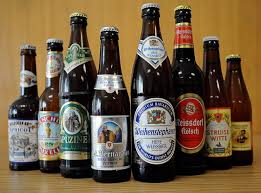

---------------------

## A new form of z-Score

As we are doing another test, we need a $\mathit{z}$-Score to calculate later the $\mathit{p}$-Value.

What happens now? Now that we have 2 samples as the population is divided in 2 types, the German and Belgian beers, we need to take the difference between the samples in all of the cases. This means, that calculating the $\mathit{z}$-Score now is done in the following way:

$$\mathit{t} = \frac{(\bar{x}_{German} - \bar{x}_{Belgian}) - (\mu_{German} - \mu_{Belgian})}{\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})}$$

Where $\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})$ is:

$$\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian}) \approx \sqrt{\frac{\mathit{s}^{2}_{German}}{n_{German}} + \frac{\mathit{s}^{2}_{Belgian}}{n_{Belgian}}}$$

- $\mathit{s}$ is the standard deviation of the variable.
- $\mathit{n}$ is the sample size.


## Simplifying z-score for two samples

Ok but this sounds so difficult, how can be simplify it? 

Do you remember that when we were doing our calculus of the $\mathit{p}$-Value we were assuming that the null hypothesis is true? If we consider that to be true, in our last example we would have:

$$ \bar{x}_{German} = \bar{x}_{Belgian}$$

Which would simplify the way we calculate $\mathit{t}$, so it is remaining:

$$\mathit{t} = \frac{(\mu_{German} - \mu_{Belgian})}{\mathit{SE}(\bar{x}_{German} - \bar{x}_{Belgian})}$$

So, then **we need 6 variables:**

- 2 means, one of each group.
- 2 standard deviations, one of each group.
- The number of observations for each group.

-------------------------

Doing this with our sample of late shipments would be in the following way. Our hypothesis are:

- $H_{0}$ = The mean weight of shipments that weren't late is the same as the mean weight of shipments that were late.
- $H_{A}$ = The mean weight of shipments that weren't late is LESS THAN the mean weight of shipments that were late.

In [47]:
late_shipments['late'] = late_shipments['late'].map({1: 'Yes', 0: 'No'})

# Sample means
xbar_yes = late_shipments[late_shipments["late"]=="Yes"].weight_kilograms.mean()
xbar_no = late_shipments[late_shipments["late"]=="No"].weight_kilograms.mean()

# Sample standard deviations
s_yes = late_shipments[late_shipments["late"]=="Yes"].weight_kilograms.std()
s_no = late_shipments[late_shipments["late"]=="No"].weight_kilograms.std()

# Number of elements of each group
n_yes = len(late_shipments[late_shipments["late"] == "Yes"])
n_no = len(late_shipments[late_shipments["late"] == "No"])

numerator = xbar_yes - xbar_no
denominator = np.sqrt(s_yes**2/n_yes + s_no**2/n_no)

t_stat = -1 * (numerator/denominator)   #We put it with the NEGATIVE SQUAREROOT because it is Left-Tailed
t_stat

-2.3936661778766433

## t-Distribution and Degrees of Freedom

We have calculated the $\mathit{t}$-statistic for our problem, but how do we obtain the $\mathit{p}$-Value?
We need to find now the distribution that follows the "$\mathit{z}$-Score of the two samples", that is, the $\mathit{t}$-stat.

It is called the **$\mathit{t}$-distribution.**

$\mathit{t}$-distribution is a distribution type that is based on a central mean of the population (Remember that $\mathit{t}$-test is used for means, that´s why!) but with the peculiarity that the standard deviation is unkwown. In it´s base form it is equal to the normal distribution, so the bigger the parameter Degrees of Freedom, the similarity is bigger between both distributions.

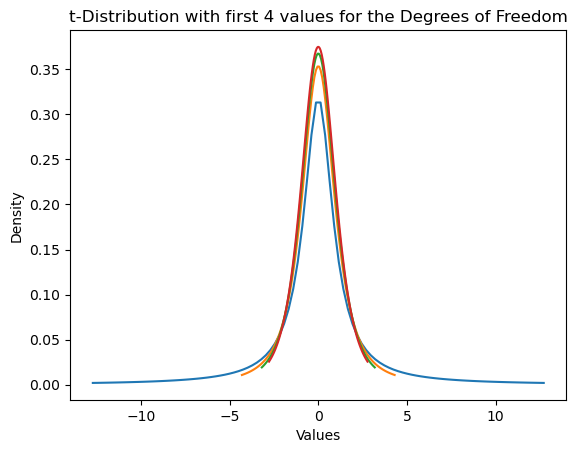

In [48]:
for df in range(1,5):
# Generate random data from a t-distribution with 1,2,3 and 4 degrees of freedom
    x = np.linspace(t.ppf(0.025, df),t.ppf(0.975, df), 100)
    y = t.pdf(x, df)
    plt.plot(x, y)

plt.title('t-Distribution with first 4 values for the Degrees of Freedom')
plt.xlabel('Values')
plt.ylabel('Density')

plt.show()

Now, what are degrees of freedom? 

**Degrees of freedom** are the maximum number of logically independent values in the data sample. 
Let´s put an example. Again, with beers.

Let´s say that I have taken 3 beers tonight having dinner with my friends! But I don´t remember which beers I ahve consumed. Nevertheless, one of my friends that is mathematician told me that I have drunk beers that have a mean of 4.5% degrees of alcohol. 

I remember that I have taken a soft beer of 4 degrees and another one a bit stronger of 5 degrees. So basically, we have the following equation:

$$4.5\% = \frac{4\% + 5\% + \mathit{x}}{3}$$

The remaining beer is 4.5% degrees!

The point is that, we could select whatever beer we prefered, **but we were "forced" to drink one of 4.5%, due to the fact that the mean forces us to have drunk one with that percentage**. The other two, that we have drunk **freely**, are the **degrees of freedom** of our equation.

Notice that if we have drunk two beers of 5%, the value of $\mathit{x}$ would be 3.5% so we have 2 beers of 5% that we picked freely, but the last one is again forced to be a certain quantity.

So, what are the degrees of freedom from our equation? 
- We have two means that are the weight of shipments that arrived at time and arrived late.
- We have the observations of both groups.

So our degrees of freedom would be:
$$df = n_{late} + n_{at_time} - 2$$

In the germans and belgian beer cases:
$$df = n_{German} + n_{Belgian} - 2$$

------

Let´s do the test now, we are going to use the $\mathit{t}$-test statistic, but we have to consider some things:
- Our $H_{A}$ is a **less than** hypothesis so it is a left-tailed test. So to calculate the $\mathit{p}$-Value now we do not do 1-cdf(), just cdf() as it counts the accumulation from left to right.
- We need to calculate the the degrees of freedom.
- We will use a significance level of $\alpha$ = 0.05.

Let´s do it:

In [49]:
degrees_of_freedom = n_yes + n_no - 2 #Calculated above the number of elements
p_value = t.cdf(t_stat,df= degrees_of_freedom)  #We use the method cdf from scipy.stats

p_value

0.008432382146249523

We have obtained that $\mathit{p} < \alpha$ so that means that we reject $H_{0}$ and we can assure that our hypothesis is consistent with a 95% of precision that the mean weight of shipments that weren't late is less than the mean weight of shipments that were late.

We have performed a $\mathit{t}$-test!

---------

## Paired t-test

A paired $\mathit{t}$-test is just an special type of $\mathit{t}$-test that compares two populations that have been conditioned due to a certain event. It is specially common if we compare two situations in different time moments.

Some examples of paired $\mathit{t}$-test are:

- Compare if the notes in maths are better in the first semester than the second semester.
- Compare if the beer´s flavour has improved in the last four years or remains the same.

To do it, we need to store the variables rather than differenciating by a value, by making their difference.

If we take the case of beers again, having in consideration that $\mu$ now represent the flavour in different years, we would be comparing:

- $H_{0}$: $\mu_{German_{2024}} - \mu_{German_{2020}} = 0$
- $H_{A}$: $\mu_{German_{2024}} - \mu_{German_{2020}} > 0$

By differenciating them, the problem simplifies to:

- $H_{0}$: $\mu_{German Diff.} = 0$
- $H_{A}$: $\mu_{German Diff.} > 0$

Also, calculating $\mathit{t}$ is easier as is the same population:

$$t = \frac{\bar{x}_{German Diff.} - \mu_{German Diff.}}{\sqrt{\frac{\mathit{s}^{2}_{German Diff.}}{\mathit{n}_{German Diff.}}}}$$
And also because the test are made supposing that we follow a distribution based on $H_{0}$, it agains simplify as:

$$t = \frac{\bar{x}_{German Diff.}}{\sqrt{\frac{\mathit{s}^{2}_{German Diff.}}{\mathit{n}_{German Diff.}}}}$$

And the degrees of freedom also are less, as now they are unified:

$$df = n_{German diff.} - 1$$

## The pingouin package

The pingouin package allows us to do this calculations much faster, but it is importat to understand the underlying knowledge of the test. We can use it to print the results as a DataFrame.

Using the second dataset presented:

In [50]:
sample_dem_data = pd.read_feather("dem_votes_potus_12_16.feather")
sample_dem_data.head()   #We will use the last 2 columns

,state,county,dem_percent_12,dem_percent_16
0,Alabama,Bullock,76.305900,74.946921
1,Alabama,Chilton,19.453671,15.847352
2,Alabama,Clay,26.673672,18.674517
3,Alabama,Cullman,14.661752,10.028252
4,Alabama,Escambia,36.915731,31.020546


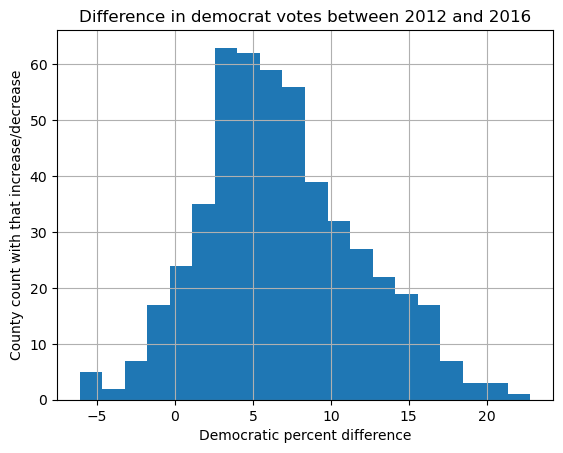

In [51]:
# Calculate the differences from 2012 to 2016
sample_dem_data['diff'] = sample_dem_data['dem_percent_12'] - sample_dem_data['dem_percent_16']
xbar_diff = sample_dem_data['diff'].mean()

# Find the standard deviation of the diff column
s_diff = sample_dem_data['diff'].std()

sample_dem_data['diff'].hist(bins = 20)
plt.title("Difference in democrat votes between 2012 and 2016")
plt.xlabel("Democratic percent difference")
plt.ylabel("County count with that increase/decrease")
plt.show()

Notice that it is almost to the right of 0 most of the times so it means that uring that elections the democrats increased the votes in almost all counties.

Knowing that, we can do the following hypothesis tests:

- $H_{0}$: The proportion of democratic votes in 2012 and 2016 were the same. 
- $H_{A}$: The proportion of democratic votes in 2012 and 2016 were different.

We will assume $\alpha$ = 0.01.

Using the **pingouin packeage**:

In [52]:
# Conduct a t-test on diff
test_results = pingouin.ttest(x=sample_dem_data['diff'], 
                              y=0, 
                              alternative="two-sided")

# Alternative to obtain the same result:
paired_test_results = pingouin.ttest(x=sample_dem_data['dem_percent_12'], 
                                     y=sample_dem_data['dem_percent_16'],
                                     paired=True,
                                     alternative="two-sided")

test_results

NameError: name 'pingouin' is not defined

As the $\mathit{p}$-value = 3.601e-115 is less than $\alpha$, we reject the null hypothesis, this is that we replace it by $H_{A}$: The proportion of democratic votes in 2012 and 2016 were different.

-----------------------------

# ANOVA Test



We have seen that we can do hypothesis test in the sampe group or in two groups, but what do we do in case that there are more than two groups?

With the pingouin package is much easier than doing it one by one, you just need to use the function pingouin.anova()!

Returning to the case of late shipments, we see that there are different ship methods, and each method can vary in several things. For this case, we are interested in the price variation of the shipment. With beers, we could take several beers from diferent nationalities to compare them such as Spanish, Italians, Germans, Belgians or Americans.

Let´s have an idea on how the shipment mode affects the pack price through a boxplot plot and then, we perform an ANOVA testto see if that variations are real:

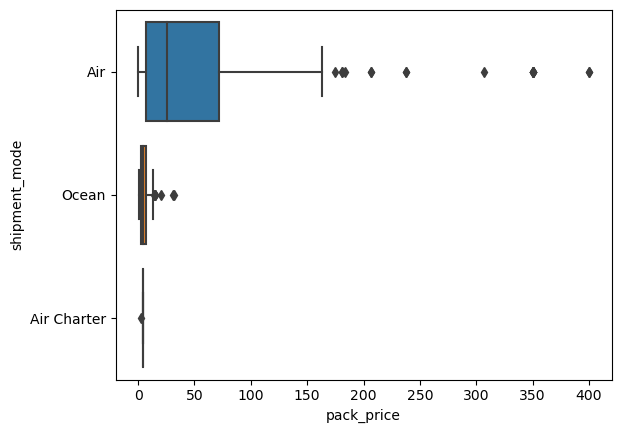

In [54]:
# Calculate the mean pack_price for each shipment_mode
xbar_pack_by_mode = late_shipments.groupby("shipment_mode")['pack_price'].mean()
# Calculate the standard deviation of the pack_price for each shipment_mode
s_pack_by_mode = late_shipments.groupby("shipment_mode")['pack_price'].std()
# Boxplot of shipment_mode vs. pack_price
sns.boxplot(x = "pack_price", y = "shipment_mode", data = late_shipments)
plt.show()

Certainly there´s a difference between deploy of the packages, but is it statistically relevant?

We will take a significance value of $\alpha$ = 0.1

In [55]:
# Run an ANOVA for pack_price across shipment_mode
anova_results = pingouin.anova( data = late_shipments, \
                                dv = "pack_price", #Comparing pack_price \    
                                between = "shipment_mode") # Between shipment modes.

# Print anova_results
print(anova_results)

          Source  ddof1  ddof2        F         p-unc       np2
0  shipment_mode      2    997  21.8646  5.089479e-10  0.042018


We see that $\alpha$ > $\mathit{p}$ so we can assume that there are differences in pack prices depending on the shipment mode.

The problem right now is, which one of the shipment modes is the one that makes that difference? That´s when we should use the **pairwise**-test, that allows us to compare directly each one of the categories had differences.

In [56]:
# Perform a pairwise t-test on pack price, grouped by shipment mode
pairwise_results = pingouin.pairwise_tests(data=late_shipments, 
                                           dv="pack_price",
                                           between="shipment_mode",
                                           padjust="none")

pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,15.277,-0.423775


Looking at the p-unc column we can obtain the p-value of each case, but the problem of ANOVA is that **the more groups are involved, the bigger the probability of a false positive we have**

To avoid false positives of the pairwise function, we use an adjustment method that restricts more this function, that is called the Bonferroni correction. It is important to put is as **with only 5 groups the possibility of having a false positive is around 50%**. It is expressed in the results as the column **p_corr** .

Other method are Sidak or Benjamini/Hordberg adjustments, that can be use too.

In [57]:
# Modify the pairwise t-tests to use Bonferroni p-value adjustment
pairwise_results = pingouin.pairwise_tests(data=late_shipments, 
                                           dv="pack_price",
                                           between="shipment_mode",
                                           padjust="bonf")     

pairwise_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,shipment_mode,Air,Air Charter,False,True,21.179625,600.685682,two-sided,8.748346e-75,2.624504e-74,bonf,5.809e+76,0.726592
1,shipment_mode,Air,Ocean,False,True,19.335760,986.979785,two-sided,6.934555e-71,2.080367e-70,bonf,1.129e+67,0.711119
2,shipment_mode,Air Charter,Ocean,False,True,-3.170654,35.615026,two-sided,3.123012e-03,9.369037e-03,bonf,15.277,-0.423775


Because all p-corr values are less than $\alpha$, we reject $H_{0}$ and we determine that all shipment methods have different prices.

-----------------------

Notebook two coming soon!